## Comparison
Providing results for comparison with other fair classification approaches.

In [10]:
import os, sys
import numpy as np
sys.path.append('../')  # the code for fair classification is in this directory

import time
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
from SMOTEBoost import SMOTEBoost 
from loaders.load_adult import load_adult
from loaders.load_bank import load_bank
from loaders.load_compas_data import load_compas
from loaders.load_kdd import load_kdd
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score

In [70]:
def display_metrics(metrics, metrics_filename='metrics.txt'):
    print(f'Accuracy: {np.mean(metrics["test_scores"]["test_accuracy"])} \
    std:{np.std(metrics["test_scores"]["test_accuracy"])}')
    print(f'Balanced_accuracy: {np.mean(metrics["test_scores"]["Balanced accuracy"])}')
    print(f'Eq.Odds: {np.mean(metrics["test_scores"]["Eq.Odds"])}')
    print(f'TPR Prot.: {np.mean(metrics["test_scores"]["TPR prot"])} ')
    print(f'TPR Non-Prot.: {np.mean(metrics["test_scores"]["TPR non-prot"])}')
    print(f'TNR Prot.: {np.mean(metrics["test_scores"]["TNR prot"])}')
    print(f'TNR Non-Prot.: {np.mean(metrics["test_scores"]["TNR non-prot"])}')
    
    metrics_out = open(metrics_filename, 'a')
    metrics_out.write(f'Model: SMOTEBoost')
    metrics_out.write(f'Accuracy: {np.mean(metrics["test_scores"]["test_accuracy"])} \
    std:{np.std(metrics["test_scores"]["test_accuracy"])}')
    metrics_out.write(f'Balanced_accuracy: {np.mean(metrics["test_scores"]["Balanced accuracy"])}')
    metrics_out.write(f'Eq.Odds: {np.mean(metrics["test_scores"]["Eq.Odds"])}')
    metrics_out.write(f'TPR Prot.: {np.mean(metrics["test_scores"]["TPR prot"])} ')
    metrics_out.write(f'TPR Non-Prot.: {np.mean(metrics["test_scores"]["TPR non-prot"])}')
    metrics_out.write(f'TNR Prot.: {np.mean(metrics["test_scores"]["TNR prot"])}')
    metrics_out.write(f'TNR Non-Prot.: {np.mean(metrics["test_scores"]["TNR non-prot"])}')
    metrics_out.close()

In [57]:
def GridSearch(X_val, y_val, n_estimators=np.arange(10, 100, 5), n_samples=(100, 200), lr=(0.1, 0.5, 1)):
    opt_n_estimators, opt_n_samples, opt_lr = 0, 0, 0
    params = list(product(n_estimators, n_samples, lr))
    min_balanced_accuracy = 0
    for (n_estimators_it, n_samples_it, lr_it) in params:
        smote_boost = SMOTEBoost(n_estimators=n_estimators_it, n_samples=n_samples_it, learning_rate=lr_it,
                                storePerfomance=False, X_test=X_val, y_test=y_val)
        smote_boost.fit(X_val, y_val)
        balanced_accuracy = balanced_accuracy_score(y_val, smote_boost.predict(X_val))
        if balanced_accuracy > min_balanced_accuracy:
            min_balanced_accuracy = balanced_accuracy
            opt_n_estimators, opt_n_samples, opt_lr = n_estimators_it, n_samples_it, lr_it
    
    print('GridSearch result:')
    print(f'Optimal number of estimators: {opt_n_estimators}')
    print(f'Optimal number of samples: {opt_n_samples}')
    print(f'Optimal learning rate: {opt_lr}')
    return opt_n_estimators, opt_n_samples, opt_lr

In [51]:
def eval_model(loader, sensativeAttribute='', grid_search=False, n_estimators=50, n_samples=100, lr=1):
    if sensativeAttribute == '':
        X, y, sa_index, p_Group, x_control = loader()
    else:
        X, y, sa_index, p_Group, x_control = loader(sensativeAttribute)
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
    opt_n_estimators, opt_n_samples, opt_lr = n_estimators, n_samples, lr
    if grid_search:
        X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.7)
        opt_n_estimators, opt_n_samples, opt_lr = GridSearch(X_val, y_val)
    smote_boost = SMOTEBoost(n_estimators=opt_n_estimators, n_samples=opt_n_samples, 
                                        storePerfomance=True, saIndex=sa_index, learning_rate=opt_lr, 
                                        saValue=p_Group, X_test=X_test, y_test=y_test)
    smote_boost.fit(X_train, y_train)
    display_metrics(smote_boost.get_performance_over_iterations()[-1]) 

In [53]:
eval_model(load_bank, dataset_name='bank', n_estimators=200)

Accuracy: 0.884761544227886     std:0.00023929263015588057
Balanced_accuracy: 0.7497830863890187
Eq.Odds: 0.10987743763672964
TPR Prot.: 0.5255847953216374 
TPR Non-Prot.: 0.6072572038420491
TNR Prot.: 0.9493506493506494
TNR Non-Prot.: 0.9211456202343314


In [54]:
eval_model(load_compas, sensativeAttribute="sex", n_estimators=200, n_samples=2)

Counter({'Male': 4247, 'Female': 1031})
Features we will be using for classification are: ['age_cat_25 - 45', 'age_cat_Greater than 45', 'age_cat_Less than 25', 'race', 'sex', 'priors_count', 'c_charge_degree', 'target'] 

Accuracy: 0.6547845373891     std:0.02238936033005612
Balanced_accuracy: 0.6715311556948075
Eq.Odds: 0.5720339555082817
TPR Prot.: 0.4717948717948718 
TPR Non-Prot.: 0.770048309178744
TNR Prot.: 0.8284023668639053
TNR Non-Prot.: 0.5546218487394958


In [55]:
eval_model(load_adult, sensativeAttribute="sex", n_estimators=200)

Accuracy: 0.7489817523528561     std:4.446342177790719e-05
Balanced_accuracy: 0.8186313253283344
Eq.Odds: 0.4948184052755933
TPR Prot.: 0.6076555023923444 
TPR Non-Prot.: 0.8611915597848573
TNR Prot.: 0.9621188789651987
TNR Non-Prot.: 0.7208365310821182


In [56]:
eval_model(load_kdd, sensativeAttribute='', n_estimators=50, n_samples=500)

Accuracy: 0.9435991120866267     std:0.0011518067300757774
Balanced_accuracy: 0.694814123653508
Eq.Odds: 0.27619926752427404
TPR Prot.: 0.20573183213920163 
TPR Non-Prot.: 0.4586220953933958
TNR Prot.: 0.99474113223423
TNR Non-Prot.: 0.9714321279641501


## Verifaction of the algorithm
In this part of the notebook we verify SMOTEBoost algorithm by comparing aquired results with graphs presented in the article on two datasets satimage and phomene: SMOTEBoost: Nitesh V Chawla, Aleksandar Lazarevic, Lawrence O Hall, and Kevin W Bowyer. 2003. SMOTEBoost: Improving prediction of the minority class in boosting. In ECML PKDD. Springer, 107–119

In [4]:
def load_phomene_dataset():
    dataset_path = '../data/phomene.csv'
    phomene_ds = pd.read_csv(dataset_path)
    X = phomene_ds.iloc[:, :-1]
    y = phomene_ds.iloc[:, -1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    return X_train, X_test, y_train, y_test 

In [8]:
X_train, X_test, y_train, y_test = load_phomene_dataset()
smote_boost = SMOTEBoost(n_estimators=20, n_samples=200, storePerfomance=True, 
                         X_test=X_test.to_numpy(), y_test=y_test.to_numpy(), ignoreSensitiveFeature=True)
smote_boost.fit(X_train.to_numpy(), y_train.to_numpy())
performances = smote_boost.get_performance_over_iterations()
f1_score = [np.mean(performances[i]['test_scores']['f1_score']) for i in range(len(performances))]
recall = [np.mean(performances[i]['test_scores']['test_recall']) for i in range(len(performances))]
precision = [np.mean(performances[i]['test_scores']['test_precision']) for i in range(len(performances))]

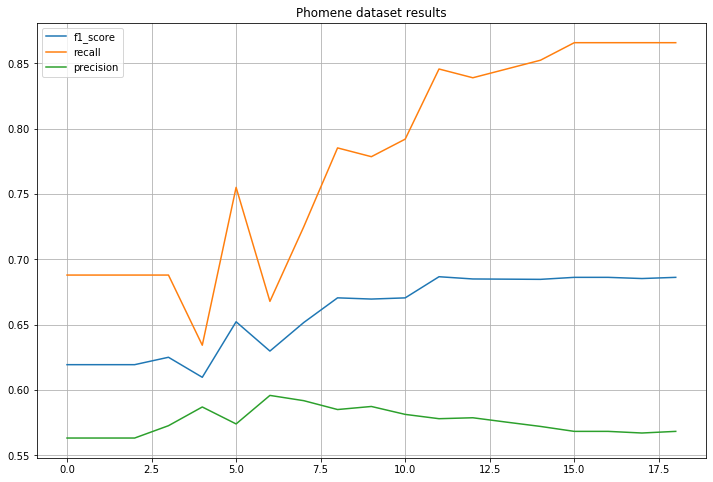

In [18]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_title('Phomene dataset results')
ax.plot(f1_score, label='f1_score')
ax.plot(recall, label='recall')
ax.plot(precision, label='precision')
ax.grid()
ax.legend()

In [23]:
def load_satimage_dataset():
    dataset_path = '../data/satimage.csv'
    satimage_ds = pd.read_csv(dataset_path)
    satimage_ds['label'].replace(to_replace=[1, 2, 3, 5, 7], value=0, inplace=True)
    satimage_ds['label'].replace(to_replace=[4], value=1, inplace=True)
    X = satimage_ds.iloc[:, :-1]
    y = satimage_ds.iloc[:, -1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    return X_train, X_test, y_train, y_test 

In [ ]:
X_train, X_test, y_train, y_test = load_satimage_dataset()
smote_boost = SMOTEBoost(n_estimators=20, n_samples=200, storePerfomance=True, 
                         X_test=X_test.to_numpy(), y_test=y_test.to_numpy(), ignoreSensitiveFeature=True)
smote_boost.fit(X_train.to_numpy(), y_train.to_numpy())
performances = smote_boost.get_performance_over_iterations()
# accuracy = [np.mean(performances[i]['test_scores']['test_accuracy']) for i in range(len(performances))]